In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib


c:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [20]:
path_to_data = "../results/femur_tibia_mask.nii.gz"

In [21]:
mask_vol = nib.load(path_to_data)
print(mask_vol.header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 216   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.       0.869141 0.869141 2.       1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 222.5
qoffset_y       : 222.5
qoffset_z       : -900.5
sro

Summary of Segmentation Mask
Shape: (512, 512, 216) → 216 axial slices of 512×512 pixels

Voxel size: (0.869 × 0.869 × 2.0 mm³) 

Datatype: 8-bit unsigned integer (uint8) — suitable for labeled masks

Physical size of volume (approx.):

Width: 512 × 0.869 mm ≈ 445 mm

Height: 512 × 0.869 mm ≈ 445 mm

Depth: 216 × 2.0 mm = 432 mm


In [22]:
mask = mask_vol.get_fdata() # get image array data
affine = mask_vol.affine # gets affine transformation matrix associated with the volume data
affine


array([[-8.69140983e-01,  0.00000000e+00,  0.00000000e+00,
         2.22500000e+02],
       [ 0.00000000e+00, -8.69140983e-01,  0.00000000e+00,
         2.22500000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  2.00000000e+00,
        -9.00500000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])


Matrix that describes the relationship between voxel coordinates in the image data array and real-world coordinates in a reference space



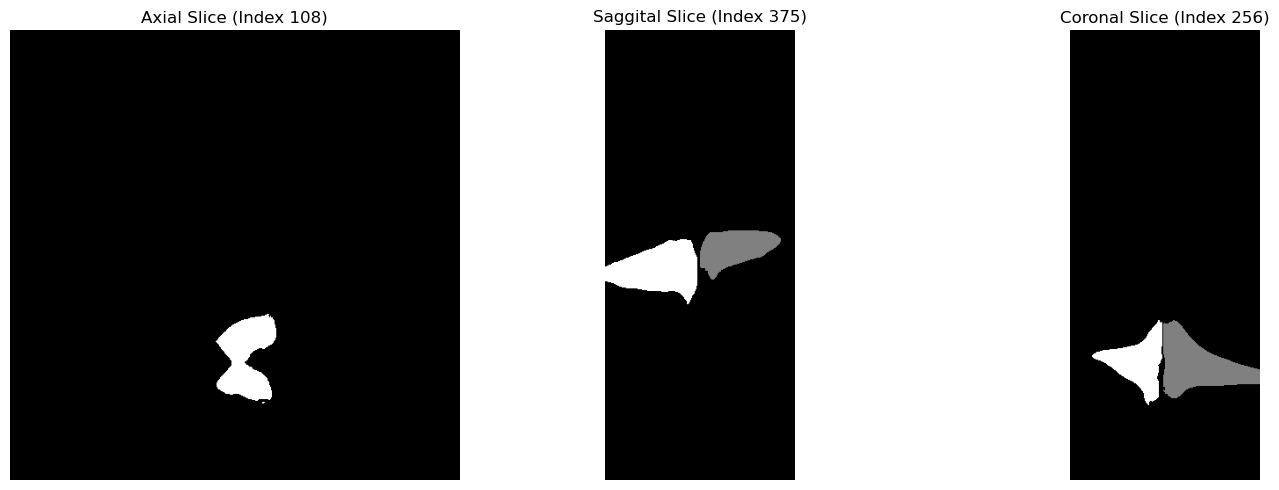

In [23]:
def plot_slices(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial slice 
    axes[0].imshow(data[:, :, 108], cmap='gray')
    axes[0].set_title('Axial Slice (Index 108)')
    axes[0].axis('off')

    # Coronal slice
    axes[1].imshow(data[375, :, :], cmap='gray')
    axes[1].set_title('Saggital Slice (Index 375)')
    axes[1].axis('off')
    # Sagittal slice
    axes[2].imshow(data[:, 256, :], cmap='gray')
    axes[2].set_title('Coronal Slice (Index 256)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

plot_slices(mask)


In [24]:
def get_voxel_spacing(affine):
    spacing_x = np.linalg.norm(affine[:3, 0])
    spacing_y = np.linalg.norm(affine[:3, 1])
    spacing_z = np.linalg.norm(affine[:3, 2])
    return spacing_x, spacing_y, spacing_z

spacing = get_voxel_spacing(affine)
print(f"Voxel spacing (mm): {spacing}")


Voxel spacing (mm): (0.8691409826278687, 0.8691409826278687, 2.0)


X   0.869   Each voxel step along X is ~0.869 mm wide

Y   0.869   Each voxel step along Y is ~0.869 mm wide

Z   2.0 Each voxel step along Z (slice thickness) is 2 mm



In [25]:
mask_vol.header.get_zooms()

(0.869141, 0.869141, 2.0)

In [26]:
# calculate how many voxels we need to expand by 2 mm
def calculate_expansion_voxels(spacing, expansion_mm=2):
    radius_voxels = [int(np.ceil(expansion_mm / s)) for s in spacing]
    return radius_voxels

calculate_expansion_voxels(spacing)


[3, 3, 1]

Round up 2.3 voxels to 3 since dilation works on discrete voxels

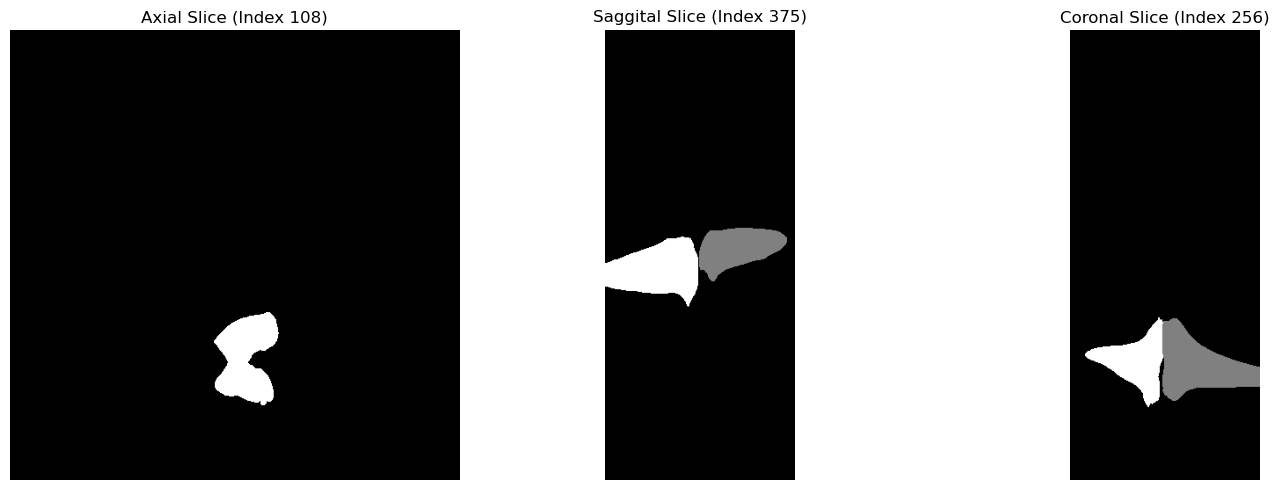

In [27]:
from scipy.ndimage import distance_transform_edt

# Separate femur and tibia masks
femur_mask = (mask == 1)
tibia_mask = (mask == 2)

def expand_mask(mask, spacing, expansion_mm):
    # Compute distance transform of the background (~mask)
    distance = distance_transform_edt(~mask, sampling=spacing)
    # Include original mask plus points within expansion_mm
    expanded = mask | (distance <= expansion_mm)
    return expanded

femur_expanded = expand_mask(femur_mask, spacing, 2)
tibia_expanded = expand_mask(tibia_mask, spacing, 2)

overlap = femur_expanded & tibia_expanded
# Remove overlap from tibia or assign priority
tibia_expanded[overlap] = False

expanded_mask = np.zeros_like(mask)
expanded_mask[femur_expanded] = 1
expanded_mask[tibia_expanded] = 2



plot_slices(expanded_mask)


In [28]:
expanded_img = nib.Nifti1Image(expanded_mask.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(expanded_img, 'expanded_mask_2mm.nii.gz')


Check distances of expanded voxels

In [29]:
# binary original mask (e.g. femur_mask)
maskk = mask.astype(bool)

# Calculate distance transform of the background (~mask)
distance = distance_transform_edt(~maskk, sampling=spacing)

# Find expanded mask boundary voxels (voxels in expanded but not in original)
expanded_boundary = (expanded_mask.astype(bool) & ~maskk)

# Get distance values on expanded boundary
distances_on_boundary = distance[expanded_boundary]

print("Max distance on expanded boundary (mm):", distances_on_boundary.max())
print("Min distance on expanded boundary (mm):", distances_on_boundary.min())
print("Mean distance on expanded boundary (mm):", distances_on_boundary.mean())



Max distance on expanded boundary (mm): 2.0
Min distance on expanded boundary (mm): 0.8691409826278687
Mean distance on expanded boundary (mm): 1.3849264905628427


Randomized Contour Adjustment

In [30]:
def randomized_contour_adjustment(original_mask, spacing, expansion_mm, seed):
   
    if seed is not None:
        np.random.seed(seed)
    
    # 1) distance (in mm) from each background voxel to original mask
    #    distance[i,j,k] = min distance (mm) to a True voxel in original_mask
    distance = distance_transform_edt(
        ~original_mask,
        sampling=spacing
    )
    
    # 2) draw a random expansion radius for *every* voxel in the volume
    #    range [0, expansion_mm]
    random_offsets = np.random.rand(*original_mask.shape) * expansion_mm
    
    # 3) build the new mask:
    #    - keep all original voxels
    #    - add background voxels only if distance <= that voxel’s random offset
    randomized = original_mask | (
        (distance <= random_offsets) &
        (~original_mask)
    )
    
    return randomized

# ---------------------------------------------------------------------
# Example usage for femur and tibia:

# assume you already have:
#   mask          : int32 ndarray with labels {0,1,2}
#   spacing       : (0.89, 0.89, 2.0)
#   expansion_mm  : 2.0

femur_mask = (mask == 1)
tibia_mask = (mask == 2)

# First randomized adjustment (seed=42)
femur_rand1 = randomized_contour_adjustment(femur_mask, spacing, 2.0, seed=42)
tibia_rand1 = randomized_contour_adjustment(tibia_mask, spacing, 2.0, seed=42)

# Second randomized adjustment (different seed)
femur_rand2 = randomized_contour_adjustment(femur_mask, spacing, 2.0, seed=99)
tibia_rand2 = randomized_contour_adjustment(tibia_mask, spacing, 2.0, seed=99)

# Combine into labeled masks
rand_mask1 = np.zeros_like(mask, dtype=np.int32)
rand_mask1[femur_rand1] = 1
rand_mask1[tibia_rand1] = 2

rand_mask2 = np.zeros_like(mask, dtype=np.int32)
rand_mask2[femur_rand2] = 1
rand_mask2[tibia_rand2] = 2

# Now you have:
#  • rand_mask1  – the first randomized expansion
#  • rand_mask2  – the second randomized expansion
# both lying between original and +2 mm, never shrinking below original.



In [36]:
expanded_img = nib.Nifti1Image(rand_mask1.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(expanded_img, 'randomized_mask_1.nii.gz')



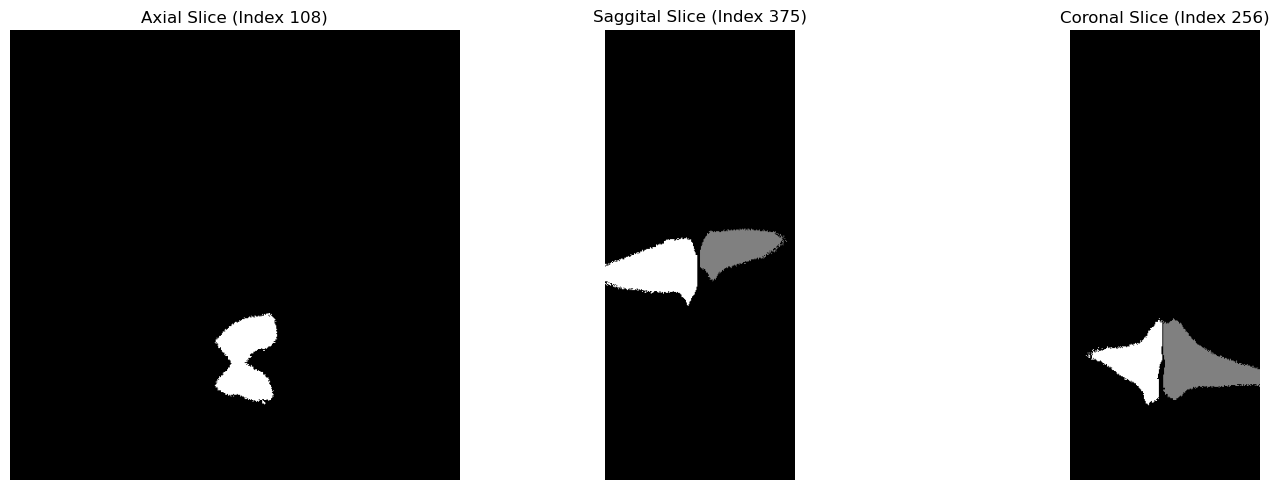

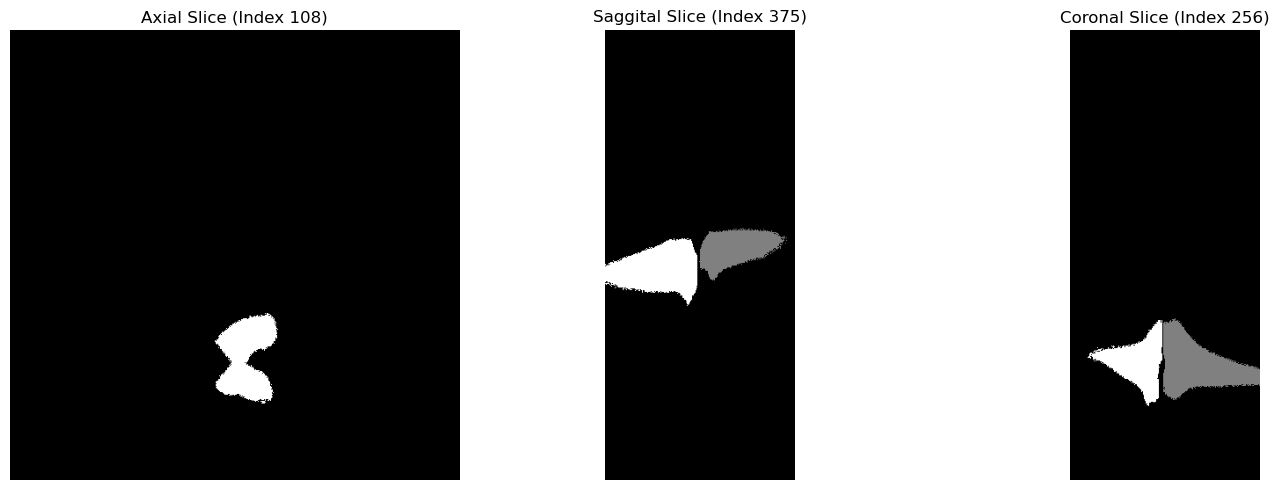

In [32]:
plot_slices(rand_mask1)
plot_slices(rand_mask2)

Check overlappping and voxel count

In [33]:
original_femur = (mask == 1)
randomized_femur = (rand_mask1 == 1)

missing_femur = original_femur & (~randomized_femur)
print(f"Missing femur voxels in randomized mask: {np.sum(missing_femur)}")

original_tibia = (mask == 2)
randomized_tibia = (rand_mask1 == 2)

missing_tibia = original_tibia & (~randomized_tibia)
print(f"Missing tibia voxels in randomized mask: {np.sum(missing_tibia)}")


missing = femur_mask & (~femur_rand1)
print(f"Missing voxels count: {np.sum(missing)}")  # should be 0



Missing femur voxels in randomized mask: 0
Missing tibia voxels in randomized mask: 0
Missing voxels count: 0


Plot to check overlapping

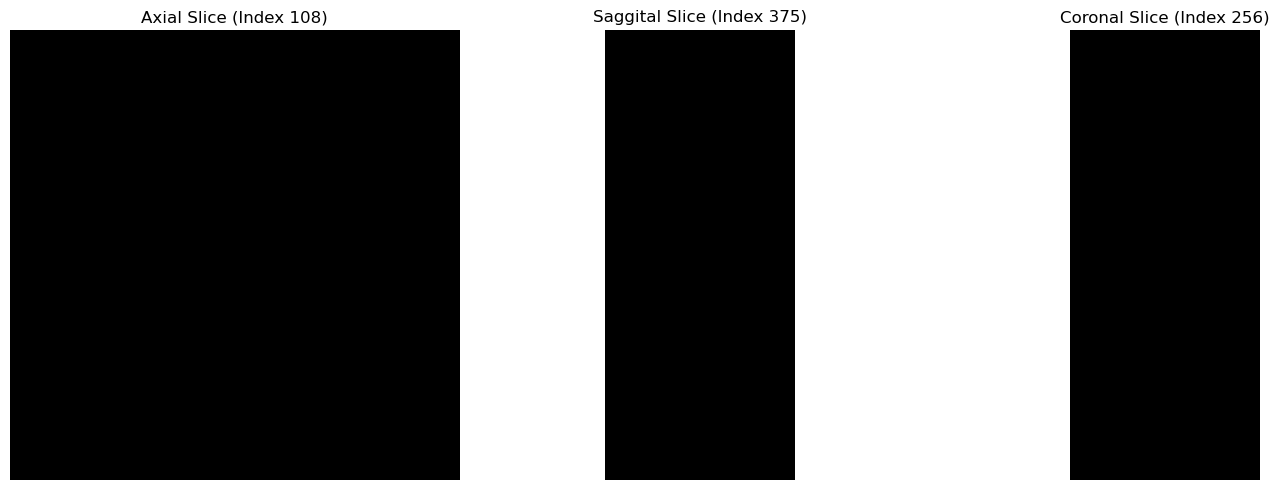

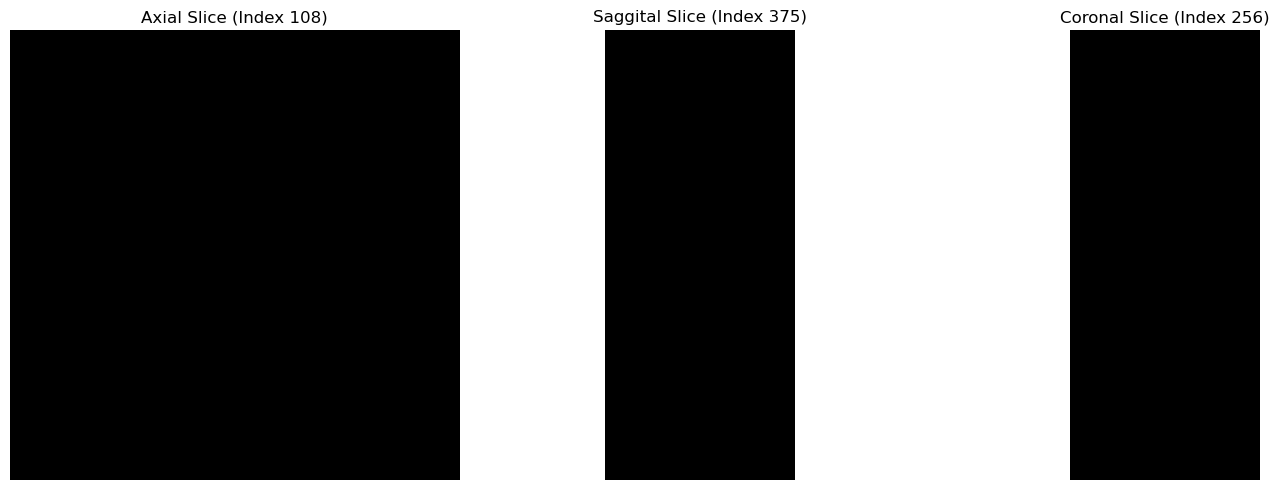

In [34]:
# For femur (label 1)
original_femur = (mask == 1)
randomized_femur = (rand_mask1 == 1)
missing_femur = original_femur & (~randomized_femur)
plot_slices(missing_femur)

# For tibia (label 2)
original_tibia = (mask == 2)
randomized_tibia = (rand_mask1 == 2)
missing_tibia = original_tibia & (~randomized_tibia)
plot_slices(missing_tibia)



In [35]:
print(f"Missing voxels count: {np.sum(missing_femur)}")  # should be 0
print(f"Missing voxels count: {np.sum(missing_tibia)}")  # should be 0


print(f"original_femur voxels count: {np.sum(original_femur)}")
print(f"randomized_femur voxels count: {np.sum(randomized_femur)}")




Missing voxels count: 0
Missing voxels count: 0
original_femur voxels count: 244063
randomized_femur voxels count: 259473
